In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def read_data_csv(filename):
    data = pd.read_csv(f"data/{filename}",sep=";")
    data.index = data["Phone timestamp"]
    data =data.drop(columns=["Phone timestamp","sensor timestamp [ns]"])
    data.index = pd.to_datetime(data.index)
    return data

In [67]:
def plot_with_markers(data,markers):
    fig, ax = plt.subplots(figsize=(15,7))
    for col in data.columns:
        ax.plot(data[col],label=col)
    for i,(start,end) in enumerate(markers):
        ax.axvspan(start,end,color='r',alpha=0.2,label="Marker" if i == 0 else "")
    
    ax.legend()
    plt.show()

In [68]:
data_passe_avant = read_data_csv("Passe_avant.csv")
markers_passe_avant = [
    (data_passe_avant.index[20],data_passe_avant.index[60]),
    (data_passe_avant.index[150],data_passe_avant.index[200]),
    (data_passe_avant.index[275],data_passe_avant.index[325]),
    (data_passe_avant.index[500],data_passe_avant.index[540]),
    (data_passe_avant.index[650],data_passe_avant.index[690]),
    (data_passe_avant.index[850],data_passe_avant.index[890]),
]

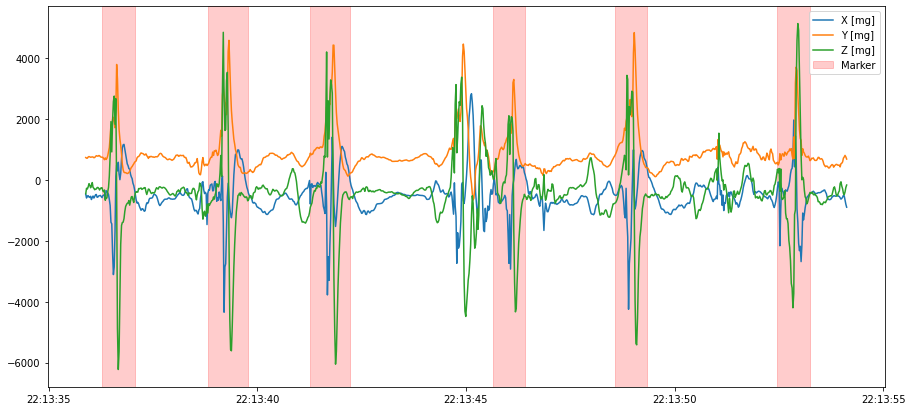

In [69]:
plot_with_markers(data_passe_avant,markers_passe_avant)

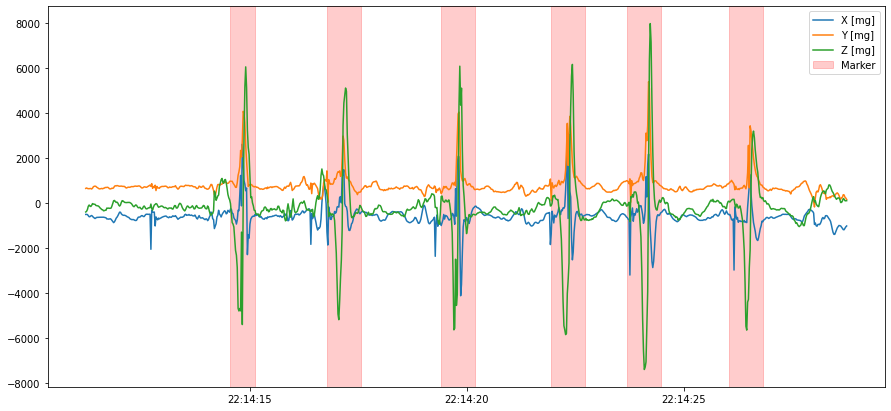

In [88]:
data_passe_backend = read_data_csv("Passe_backend.csv")
markers_passe_backend = [
    (data_passe_backend.index[170],data_passe_backend.index[200]),
    (data_passe_backend.index[285],data_passe_backend.index[325]),
    (data_passe_backend.index[420],data_passe_backend.index[460]),
    (data_passe_backend.index[550],data_passe_backend.index[590]),
    (data_passe_backend.index[640],data_passe_backend.index[680]),
    (data_passe_backend.index[760],data_passe_backend.index[800]),
]
plot_with_markers(data_passe_backend,markers_passe_backend)

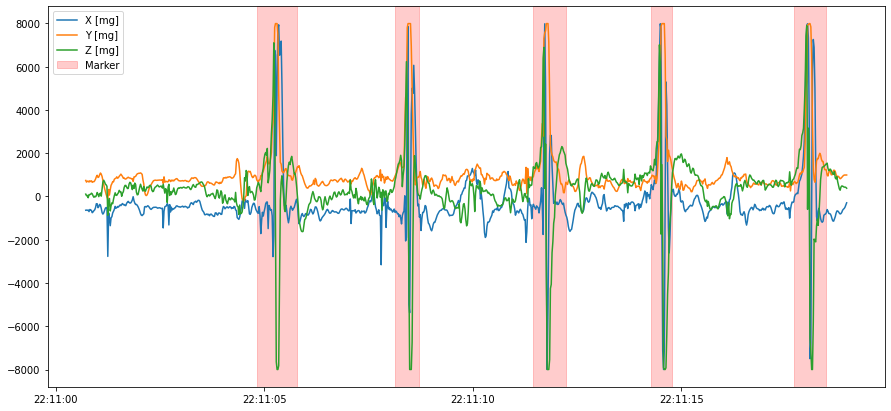

In [98]:
data_tir_avant = read_data_csv("Tir_avant.csv")
markers_tir_avant = [
    (data_tir_avant.index[210],data_tir_avant.index[260]),
    (data_tir_avant.index[380],data_tir_avant.index[410]),
    (data_tir_avant.index[550],data_tir_avant.index[590]),
    (data_tir_avant.index[695],data_tir_avant.index[720]),
    (data_tir_avant.index[870],data_tir_avant.index[910]),
]
plot_with_markers(data_tir_avant,markers_tir_avant)

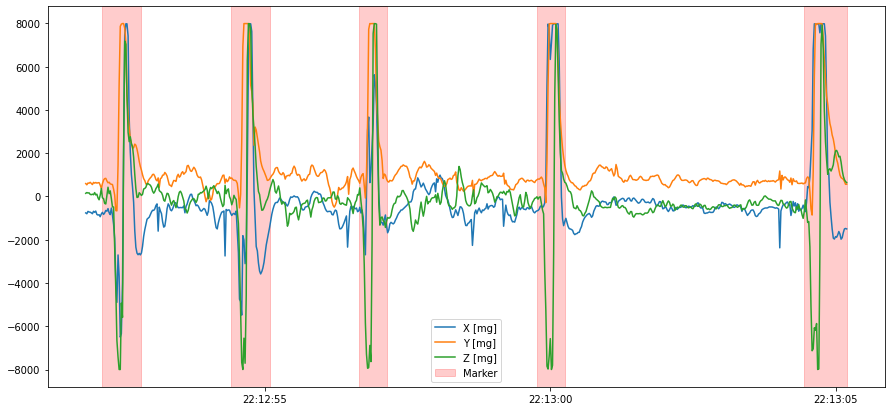

In [117]:
data_tir_backend = read_data_csv("Tir_backend.csv")
markers_tir_backend = [
    (data_tir_backend.index[15],data_tir_backend.index[50]),
    (data_tir_backend.index[130],data_tir_backend.index[165]),
    (data_tir_backend.index[245],data_tir_backend.index[270]),
    (data_tir_backend.index[405],data_tir_backend.index[430]),
    (data_tir_backend.index[640],data_tir_backend.index[-10]),
]
plot_with_markers(data_tir_backend,markers_tir_backend)